In [1]:
topic = 'from:PolkaMarkets'

In [2]:
# Parameters
topic = "betrivers"


In [3]:

testing = False

In [4]:
import time


from gensim.models.coherencemodel import CoherenceModel

from gensim.corpora import Dictionary


import re

from gensim.models.ldamodel import LdaModel


import string

from wordcloud import WordCloud, STOPWORDS
import nltk.stem.snowball as snowball

import numpy as np 
import sys
sys.path.append('/Users/jameswoodruff/Desktop/Desktop - james’s MacBook Pro/foretoken/databasetools')
import foreDataBaseTools 

import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets

import pandas as pd


from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis

import pyLDAvis


import warnings

from IPython.display import display,Javascript, Markdown as md

In [5]:
def timeit(seconds,print_=True,record=False):
    h = seconds//(60*60)
    m = (seconds-h*60*60)//60
    s = seconds-(h*60*60)-(m*60)
    if print_:
        print(f"hours: {h}\tminutes: {m}\tseconds: {s:.3f}")
    if record:
        return f"{h}h{m}m{s}s"



def CreateHourDay(df,date_col):
  df['tweet_hour' ] = pd.to_datetime(df[date_col]).dt.strftime('%Y-%m-%d %H')
  df['tweet_day' ] = pd.to_datetime(df[date_col]).dt.strftime('%Y-%m-%d')



def CreatePercentChange(df, columns):
  for c in columns:
    ci = c+'.pc'
    df[ci] = df[c].pct_change()

# function to add rolling 7 average columns
def CreateRolling(df, columns,window = 7):
  for c in columns:
    new_c = c+'.r'+str(window)
    df[new_c] = df[c].rolling(window).mean()
  df[columns] = df[columns].replace(np.inf,1).replace(-np.inf,-1).fillna(0)


def CreateForwardRolling(df, columns,window = 7):
  for c in columns:
    new_c = c+'.fr'+str(window)
    df[new_c] = df[c][::-1].rolling(window).mean()[::-1]
  df[columns] = df[columns].replace(np.inf,1).replace(-np.inf,-1).fillna(0)

## functions for displaying information
# function to clean up column names to their base
def CleanUpNames(df,columns):
  return df[columns].rename(columns = {c:c.split('.')[0].split(' base')[0] for c in columns})


def ResetMultiColumn(df):
  return [f"{c[0]}.{c[1]}" for c in df.columns]



# get tweets by groupby
def TweetMetrics(df, grain='day', relative_mean_cols = ['replyCount'
                                                      , 'retweetCount'
                                                      ,'likeCount'
                                                      , 'quoteCount']
                                ,  mean_cols = ['DistilBERT base uncased finetuned SST-2.sentiment'
                                                      ,'textblob.polarity'
                                                      , 'vader.compound'
                                                      , 'vader.neg'
                                                      , 'vader.neu'
                                                      , 'vader.pos']):
  # aggregate functions for tweets 
  def AggMetrics(x):
    d = {}
    n = x.shape[0]
    d['tweet_accounts.cnt' ] = x['username'].nunique()
    d['tweet.cnt'] = n
    # d['tweet.cnt.r'] = x['one'].rolling(window=7).sum()
    for m in relative_mean_cols:
      # d[f'{m}.r7'] = x[m].rolling(window=7).mean()
      d[f'{m}.sum'] = x[m].sum()
      d[f'{m}.mean'] = x[m].sum()/n


    for m in mean_cols:
      d[f'{m}'] = x[m].mean()    
      # d[f'{m}.r7'] = x[m].rolling(window=7).mean()

    return pd.Series(d)
  relative_mean_cols = [c for c in relative_mean_cols if c in df.columns]
  mean_cols = [c for c in mean_cols if c in df.columns]
    
  CreateHourDay(df,'tweet_date')
  df['one'] = 1
  return df.groupby([f'tweet_{grain}']).apply(AggMetrics).reset_index()



def SentimentPieChart(algorithm = 'vader.compound', show=False):
  bins = pd.DataFrame({'sentiment': pd.cut(tweets_with_sent[algorithm], bins = [-np.inf, -.01, .01, np.inf], labels = ['-', '0', '+'])})
  bins['n'] = 1

  bins_grouped = bins.groupby('sentiment').agg({'n':'sum'}).reset_index()

  # Pie chart
  labels = bins_grouped['sentiment']
  sizes = bins_grouped['n']
  #colors
  colors = ['#ff9999','#66b3ff','#99ff99']
  
  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
  # Equal aspect ratio ensures that pie is drawn as a circle
  ax1.axis('equal')  
  # plt.tight_layout()
  # plt.title(algorithm)
  if show:
    plt.show()
    
    
def CreateWordCloud(series):
  return WordCloud().generate(' '.join(series))

def PlotWordCloud(series,ax,nm):
  wc = CreateWordCloud(series)
  ax.imshow(wc) 
  ax.axis("off") 
  # axes[0].tight_layout(pad = 0) 
  ax.set_title(nm)    


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=num_topics, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)
#         (mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [6]:

sns.set({"figure.dpi":100
        , 'savefig.dpi':300
        ,'figure.figsize':(11.7,8.27)})
sns.set_style("white")

colors_fore_blue ='#02e5e9'

start_time = time.time()

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



if testing:
    tweets_with_sent = pd.read_csv('/Users/jameswoodruff/Desktop/Desktop - james’s MacBook Pro/foretoken/analysis/Twitter/Tweet Analysis/test_data.csv')
else:
    tweets = foreDataBaseTools.ReadDatabase(f"""SELECT
                                       *
                                       , LAST_DAY(tweet_date) as emonth

                                      FROM
                                        Twitter.TweetsDeDuped
                                      WHERE 
                                        topic = '{topic}'""")

    sent_df = foreDataBaseTools.ReadDatabase(f"""SELECT
                                       tsen.*
                                      FROM
                                        Twitter.TweetSentiment tsen
                                      INNER JOIN 
                                        Twitter.TweetsDeDuped dd
                                      ON
                                        dd.id = tsen.id
                                        AND dd.topic = '{topic}'

                                        """)





    sent_df = sent_df.pivot_table(index='id'
                  ,columns = ['algorithm','metric']
                  ,values='value'
                  ,aggfunc = 'mean')

    sent_df.columns = ResetMultiColumn(sent_df)
    sent_df.reset_index(inplace=True)


    tweets_with_sent = pd.merge(tweets
                                ,sent_df
                                ,how = 'left'
                                ,on = 'id')

# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('.')].sample(10).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('http')].sample(10)).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('@')].sample(10)).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('#')].sample(10)).to_csv('test_data.csv',index=False)



In [7]:
compare_mets = [
'tweet.cnt'
,'tweet_accounts.cnt'
,'replyCount.mean'
,'retweetCount.mean'
,'likeCount.mean'
,'quoteCount.mean']
if 'DistilBERT base uncased finetuned SST-2' in tweets_with_sent.columns:
    compare_mets.append('DistilBERT base uncased finetuned SST-2.sentiment')
if 'textblob.polarity' in tweets_with_sent.columns:
    compare_mets.append('textblob.polarity')
if 'vader.compound' in tweets_with_sent.columns:
    compare_mets.append('vader.compound')    


grain = 'day'

time_df = TweetMetrics(tweets_with_sent,grain)

time_df[f'tweet_{grain}'] = pd.to_datetime(time_df[f'tweet_{grain}'])
time_df.sort_values(by = f'tweet_{grain}',inplace=True)
# calculate percent change
CreatePercentChange(time_df,compare_mets)

# calculate rolling
CreateRolling(time_df,[c+'.pc' for c in compare_mets])
CreateRolling(time_df,[c+'.pc' for c in compare_mets],14)



# get dictionary of metrics to graph with cleaned up names
all_metrics = dict(zip(['base'
                    , 'percent change'
                    , 'pc rolling 7'
                    , 'pc r14']
                  , [re.match(r"^(.*)\..*", c).group().replace('tweet_accounts.cnt','') if '.' in c else '' for c in [d for d in time_df.columns if 'tweet_accounts' in d]]))




In [8]:
md('# Longitudinal Summary Metrics')


# Longitudinal Summary Metrics

In [9]:
#@title Time series of relevant columns and their calculated metrics
sns.set({"figure.dpi":100
        , 'savefig.dpi':300
        ,'figure.figsize':(11.7,8.27)})
sns.set_style("white")
colors_fore_blue ='#02e5e9'

temp_sub_tab = [widgets.Output() for i in range(len(compare_mets))]
line_tab = widgets.Tab(temp_sub_tab)
for i, met in enumerate(compare_mets):
    line_tab.set_title(i,f"{met}")


    with temp_sub_tab[i]:
          cols = [c for c in time_df.columns if met in c]
          fig, axes = plt.subplots(nrows=1
                          , ncols=len(cols)
                          ,figsize=(24,8))          
          for i, (nm, met_sub) in enumerate(sorted(all_metrics.items(), key= lambda x: len(x[1]))):
            time_df.plot(x = f'tweet_{grain}'
                        ,y = met+met_sub
                        ,kind = 'line'
                        ,color = colors_fore_blue
                        ,ax = axes[i]
                        ,legend=None)
            axes[i].set_title(nm)   
          plt.show()
display(line_tab)  

In [10]:
md('# Sentiment')

# Sentiment

In [11]:
tweets_with_sent['clean_text'] = tweets_with_sent['text']\
                            .str.replace(r'(@\w+.*?)',"")\
                            .str.replace(r'(#\w+.*?)',"")\
                            .str.replace(r'[^\w\s]','')\
                            .str.replace(r'\n',' ')\
                            .str.replace(r'\t',' ')\
                            .str.replace(r'http\S+', '', regex=True)\
                            .str.replace(r'www\S+', '', regex=True)\
                            .str.lower()


In [12]:
#     # Tweet Length (by sentiment) *****

#     tweets_with_sent['textblob.sentiment'] = np.sign(tweets_with_sent['textblob.polarity'])
#     tweets_with_sent['tweet_len'] = tweets_with_sent['clean_text'].apply(lambda r: len(r))

#     sns.displot(x =  'tweet_len'
#               , hue = 'textblob.sentiment'
#               , data = tweets_with_sent
#               , kind = 'kde')
#     plt.show()

In [13]:
try:
    sent_metrics = ['textblob.polarity'
                    ,'DistilBERT base uncased finetuned SST-2.sentiment'
                      , 'vader.compound']
    temp_sub_tab = [widgets.Output() for i in range(3)]
    line_tab = widgets.Tab(temp_sub_tab)
    for i, met in enumerate(sent_metrics):
        line_tab.set_title(i,f"{met}")


        with temp_sub_tab[i]:   
          SentimentPieChart(met)
          if met ==  'vader.compound':
            sns.displot(x = 'value'
                        , data = tweets_with_sent[[c for c in tweets_with_sent.columns if 'vader' in c]].melt()
                        , kind = 'kde'
                        , hue = 'variable'
                        )
          else:
              sns.displot(tweets_with_sent[met]
                , kind = 'kde')
          plt.title(met)       
          plt.show()
    display(line_tab)
except KeyError:
    pass


In [14]:
def CreateTagList(r,text, char):
  out = []
  if char in r[text]:
    txt = r[text].split(' ')
    for c in txt:
      if len(c) > 0 and c[:len(char)] == char:
        out.append(c.replace(char,'').lower().translate(str.maketrans('', '', string.punctuation)))
  return out


tweets_with_sent['@s'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','@'), axis = 1)
tweets_with_sent['#s'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','#'), axis = 1)


def PlotAtandPound(df, col):
  temp = df[['id',col]].explode(col).groupby(col).agg({'id':'count'}).reset_index().sort_values(by='id',ascending=False)
  # who are they  the most
  sns.barplot(x = 'id'
            , y = col
            , data = temp.head(20)
            , color = colors_fore_blue)
  plt.title(f'Total {col} Count')
  plt.xlabel('')
  plt.show()
  display(temp.describe().T.style.format('{:.1f}'))




In [15]:
md('# Frequently @ twitter users')

# Frequently @ twitter users

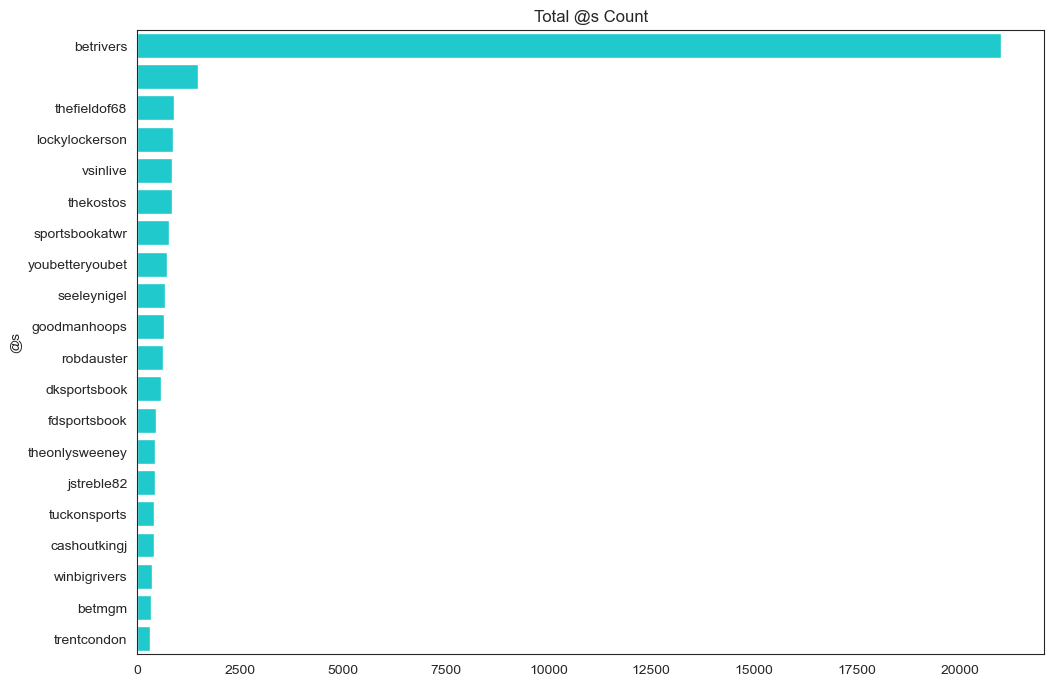

,count,mean,std,min,25%,50%,75%,max
id,8004.0,9.6,238.0,1.0,1.0,1.0,3.0,21004.0


In [16]:

PlotAtandPound(tweets_with_sent,'@s')



In [17]:
md('# Hashtags')

# Hashtags

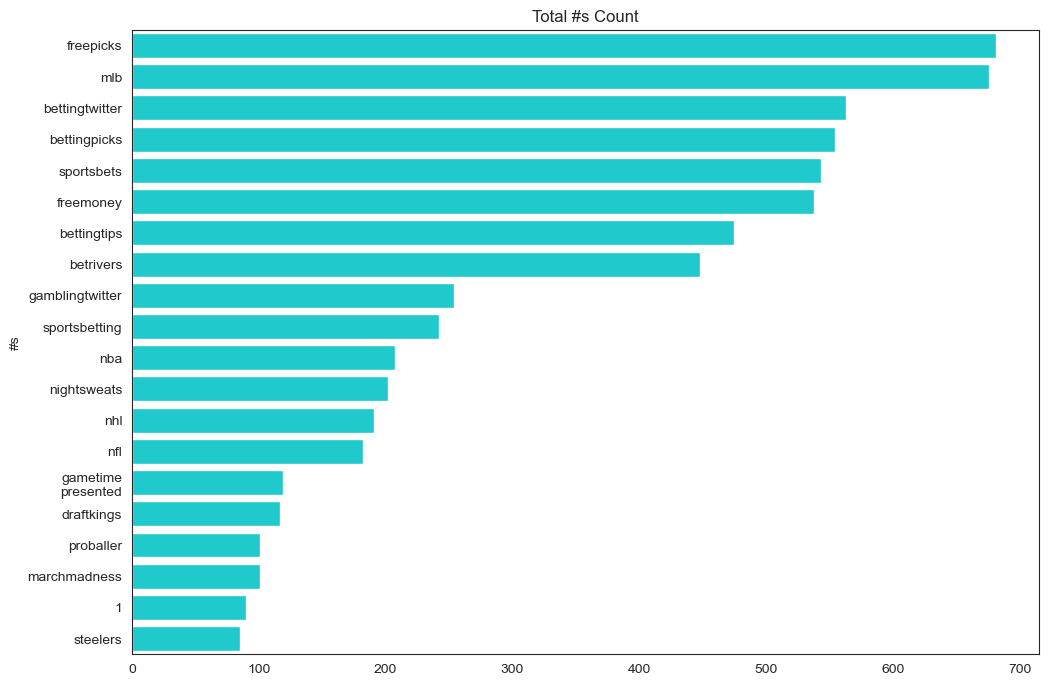

,count,mean,std,min,25%,50%,75%,max
id,2743.0,5.6,33.0,1.0,1.0,1.0,2.0,681.0


In [18]:

PlotAtandPound(tweets_with_sent,'#s')


In [19]:
md('# Linked Websites')

# Linked Websites

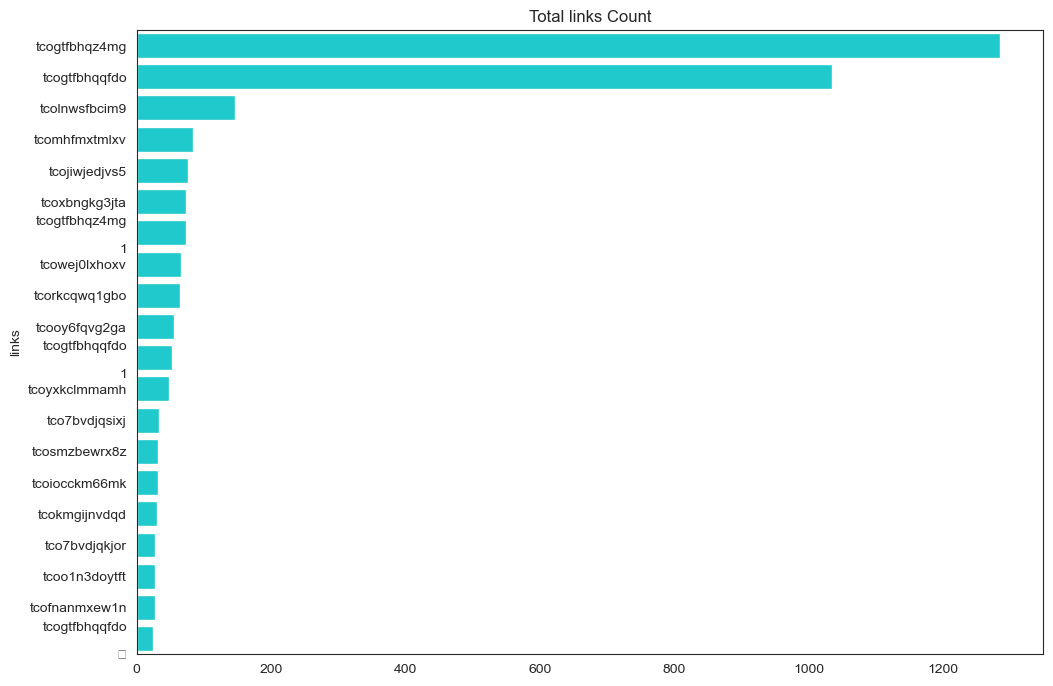

,count,mean,std,min,25%,50%,75%,max
id,15663.0,1.4,13.4,1.0,1.0,1.0,1.0,1285.0


In [20]:

tweets_with_sent['links'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','https'), axis = 1)


PlotAtandPound(tweets_with_sent,'links')


betrivers


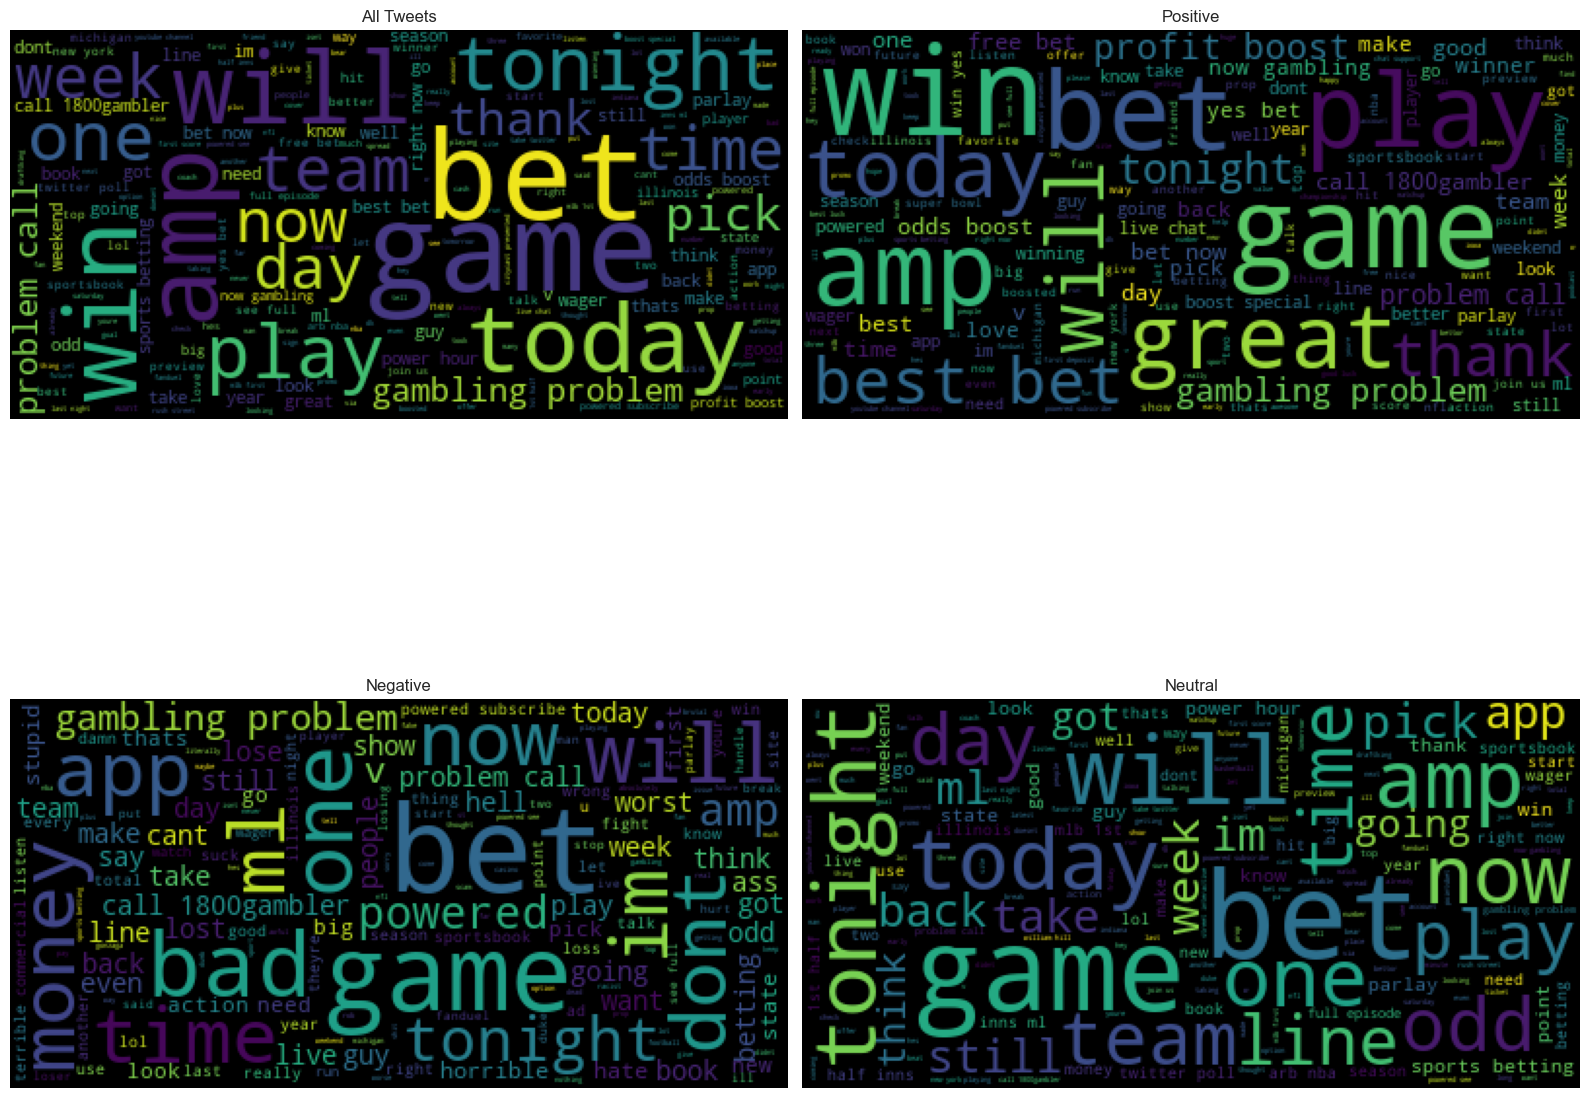

In [21]:
# Word Frequencies *****

stopwords = set(list(STOPWORDS)
               + ['https'
                  ,'https '
                  , 'co'
                  ,'com'
                  ,topic]
                + [t.lower() for t in topic.replace('from:','').replace('OR','').replace('AND', '').replace('(', '').replace(')', '').split(' ') if len(t) > 0])

tweets_with_sent['clean_text'] = tweets_with_sent['clean_text']\
                                    .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))


print(topic)

 
fig, axes = plt.subplots(nrows=2
                  , ncols=2
                  ,figsize=(16,16))
PlotWordCloud(tweets_with_sent['clean_text'],axes[0,0],'All Tweets')
try:
  PlotWordCloud(tweets_with_sent.loc[tweets_with_sent['vader.compound'] > .5]['clean_text'],axes[0,1],'Positive')
  PlotWordCloud(tweets_with_sent.loc[tweets_with_sent['vader.compound'] < -.5]['clean_text'],axes[1,0],'Negative')
  PlotWordCloud(tweets_with_sent.loc[(tweets_with_sent['vader.compound'] < .5)
                        &(tweets_with_sent['vader.compound'] > -.5)]['clean_text'],axes[1,1],'Neutral')
  fig.tight_layout()
  plt.show()
except:
  print('no sentiment')
  plt.show()

# display(line_tab)


- A word cloud is a collection, or cluster, of words depicted in different sizes. 
- The bigger and bolder the word appears, the more often it's mentioned within a given text 

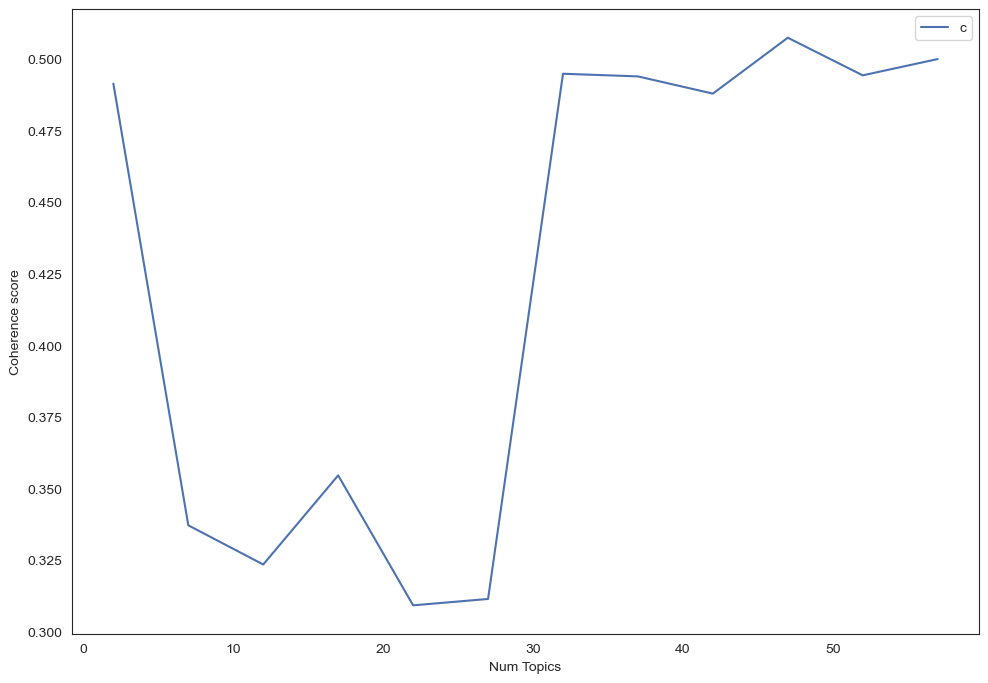

In [22]:
# Topic Modeling *****
limit = 60
start = 2
step = 5

#create dictionary
tweets = tweets_with_sent['clean_text'].values.tolist()
tweets = [t.split(' ') for t in tweets]

id2word = Dictionary(tweets)
# term document frequency
corpus = [id2word.doc2bow(text) for text in tweets]


model_list, coherence_values = compute_coherence_values(dictionary=id2word
                                                        , corpus=corpus
                                                        , texts=tweets
                                                        , start=start
                                                        , limit=limit
                                                        , step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(optimal_model
                        , corpus
                        , dictionary=optimal_model.id2word
                       , mds='mmds')
vis

/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarnin

/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jameswoodruff/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
45    -0.351693 -0.379798       1        1  6.714864
14    -0.113443 -0.490270       2        1  6.235960
28     0.306098 -0.416715       3        1  5.879272
30     0.128504 -0.487630       4        1  4.746519
4      0.245396  0.434453       5        1  4.602325
34    -0.501757 -0.040532       6        1  4.305891
8      0.116782  0.402394       7        1  3.446977
20    -0.308799  0.374900       8        1  3.411320
37    -0.107970  0.460386       9        1  3.169821
33     0.288220 -0.290674      10        1  3.119382
35     0.375784 -0.200613      11        1  3.000363
24     0.389934  0.053537      12        1  2.995671
5      0.335230  0.236387      13        1  2.905180
7      0.470713 -0.033327      14        1  2.893121
16     0.422858  0.163230      15        1  2.739354
1     -0.426384  0.113795      16        1  2.609451
3     -0.330690 -0.126021      17        1  2.605274
0      0.002747 -0.412738      18        1  2.330282
2     -0.187129 -0.335337      19        1  2.271130
21    -0.310706 -0.221894      20        1  2.236465
38    -0.183998  0.346675      21        1  2.169429
23     0.012952  0.401153      22        1  2.095023
36     0.163311 -0.278696      23        1  2.037827
29     0.359958 -0.101633      24        1  1.952878
32    -0.062678  0.278998      25        1  1.892485
10     0.236340  0.231123      26        1  1.884094
27    -0.304999  0.170777      27        1  1.454223
13     0.128004  0.268334      28        1  1.444515
31    -0.252295  0.242358      29        1  1.245960
41    -0.335187 -0.022009      30        1  1.242362
42    -0.266687  0.085548      31        1  1.048866
18     0.133090  0.038947      32        1  1.038019
17    -0.063351 -0.207083      33        1  0.994000
9      0.178024 -0.057023      34        1  0.950994
19     0.005680  0.098364      35        1  0.859902
22     0.162461  0.115898      36        1  0.775640
40    -0.137358 -0.007405      37        1  0.740548
43     0.052224 -0.150200      38        1  0.727075
39    -0.042979 -0.115118      39        1  0.671513
26    -0.166833 -0.144100      40        1  0.639734
15     0.062740 -0.053546      41        1  0.472608
12    -0.047290  0.038354      42        1  0.408586
11    -0.020022 -0.013475      43        1  0.353435
46    -0.013767  0.007553      44        1  0.171659
25    -0.013744  0.007544      45        1  0.170000
44    -0.013569  0.007571      46        1  0.170000
6     -0.013724  0.007557      47        1  0.170000, topic_info=        Term          Freq         Total Category  logprob  loglift
156      amp  14306.000000  14306.000000  Default  30.0000  30.0000
64      bets   9325.000000   9325.000000  Default  29.0000  29.0000
158      bet  10654.000000  10654.000000  Default  28.0000  28.0000
199      win   7783.000000   7783.000000  Default  27.0000  27.0000
216     game  10192.000000  10192.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
24      full      0.026827   5287.752187  Topic47 -10.2268  -5.8144
25    launch      0.026827    244.481436  Topic47 -10.2268  -2.7403
26      able      0.026827    204.647779  Topic47 -10.2268  -2.5625
27   account      0.026827    977.643171  Topic47 -10.2268  -4.1264
28    assist      0.026827     53.176123  Topic47 -10.2268  -1.2148

[2361 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
60       22  0.999020          100
420      10  0.996124           11
222      36  0.996516           12
61        1  0.992494  1800gambler
62       22  0.988098           1x
...     ...       ...          ...
264      35  0.993788          yes
240       4  0.994272    yesterday
90       17  0.998025          yet
257      38  0.990011        youll
347      33  0.997342        youre

[283 rows x 3 columns], R=30, lambda_step=0.01, pl

In [24]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
45    -0.351693 -0.379798       1        1  6.714864
14    -0.113443 -0.490270       2        1  6.235960
28     0.306098 -0.416715       3        1  5.879272
30     0.128504 -0.487630       4        1  4.746519
4      0.245396  0.434453       5        1  4.602325
34    -0.501757 -0.040532       6        1  4.305891
8      0.116782  0.402394       7        1  3.446977
20    -0.308799  0.374900       8        1  3.411320
37    -0.107970  0.460386       9        1  3.169821
33     0.288220 -0.290674      10        1  3.119382
35     0.375784 -0.200613      11        1  3.000363
24     0.389934  0.053537      12        1  2.995671
5      0.335230  0.236387      13        1  2.905180
7      0.470713 -0.033327      14        1  2.893121
16     0.422858  0.163230      15        1  2.739354
1     -0.426384  0.113795      16        1  2.609451
3     -0.330690 -0.126021      17        1  2.605274
0      0.002747 -0.412738      18        1  2.330282
2     -0.187129 -0.335337      19        1  2.271130
21    -0.310706 -0.221894      20        1  2.236465
38    -0.183998  0.346675      21        1  2.169429
23     0.012952  0.401153      22        1  2.095023
36     0.163311 -0.278696      23        1  2.037827
29     0.359958 -0.101633      24        1  1.952878
32    -0.062678  0.278998      25        1  1.892485
10     0.236340  0.231123      26        1  1.884094
27    -0.304999  0.170777      27        1  1.454223
13     0.128004  0.268334      28        1  1.444515
31    -0.252295  0.242358      29        1  1.245960
41    -0.335187 -0.022009      30        1  1.242362
42    -0.266687  0.085548      31        1  1.048866
18     0.133090  0.038947      32        1  1.038019
17    -0.063351 -0.207083      33        1  0.994000
9      0.178024 -0.057023      34        1  0.950994
19     0.005680  0.098364      35        1  0.859902
22     0.162461  0.115898      36        1  0.775640
40    -0.137358 -0.007405      37        1  0.740548
43     0.052224 -0.150200      38        1  0.727075
39    -0.042979 -0.115118      39        1  0.671513
26    -0.166833 -0.144100      40        1  0.639734
15     0.062740 -0.053546      41        1  0.472608
12    -0.047290  0.038354      42        1  0.408586
11    -0.020022 -0.013475      43        1  0.353435
46    -0.013767  0.007553      44        1  0.171659
25    -0.013744  0.007544      45        1  0.170000
44    -0.013569  0.007571      46        1  0.170000
6     -0.013724  0.007557      47        1  0.170000, topic_info=        Term          Freq         Total Category  logprob  loglift
156      amp  14306.000000  14306.000000  Default  30.0000  30.0000
64      bets   9325.000000   9325.000000  Default  29.0000  29.0000
158      bet  10654.000000  10654.000000  Default  28.0000  28.0000
199      win   7783.000000   7783.000000  Default  27.0000  27.0000
216     game  10192.000000  10192.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
24      full      0.026827   5287.752187  Topic47 -10.2268  -5.8144
25    launch      0.026827    244.481436  Topic47 -10.2268  -2.7403
26      able      0.026827    204.647779  Topic47 -10.2268  -2.5625
27   account      0.026827    977.643171  Topic47 -10.2268  -4.1264
28    assist      0.026827     53.176123  Topic47 -10.2268  -1.2148

[2361 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
60       22  0.999020          100
420      10  0.996124           11
222      36  0.996516           12
61        1  0.992494  1800gambler
62       22  0.988098           1x
...     ...       ...          ...
264      35  0.993788          yes
240       4  0.994272    yesterday
90       17  0.998025          yet
257      38  0.990011        youll
347      33  0.997342        youre

[283 rows x 3 columns], R=30, lambda_step=0.01, pl


- The further the bubbles are away from each other, the more different they are
- Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. 

In [25]:
timeit(time.time() - start_time)

hours: 2.0	minutes: 3.0	seconds: 12.665


In [26]:
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

# betrivers